**The aim of this project is to use survey data and gain insights on energy preferences and fears in Norway and Sweden**

## Imports

First, the necessarry imports are executed:

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import scipy.stats as stats
from scipy.stats import spearmanr

## Data Manipulation

Data was downloaded from the European Social Survey website (https://ess.sikt.no/en/datafile/ffc43f48-e15a-4a1c-8813-47eda377c355/92?tab=0), and now some data manipulation is executed to isolate the variables of interest and the observations / subjects that answered all questions. Regarding the energy preferences, individuals were asked how much of a give energy source should be used to generate power in the country. Regarding the concerns, subjects were asked how worried they are about issues such as climate change or energy expenses. Detailed information can be found on the ESS page and in the documentation. These variables are all ordinal.

In [16]:
file_path = '/Users/ben/[etc...]'

# Putting the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Keeping only the relevant columns
columns_to_keep = ['cntry', 'wrenexp', 'wrdpimp', 'wrdpfos', 'wrntdis', 'wrtcfl', 'wrenexp', 'wrpwrct', 'wrinspw', 'wrclmch', 'elgcoal', 'elgngas', 'elghydr', 'elgnuc', 'elgsun', 'elgwind', 'elgbio']
df = df[columns_to_keep]

# Dropping rows where `cntry` is not in the specified list
countries_to_keep = ["NO", "SE"]
df = df[df['cntry'].isin(countries_to_keep)]

df = df.loc[:, ~df.columns.duplicated()]

# Dropping rows based on specific conditions (All the values that are dropped correspond to answers like ("refusal" and "don't know"))
df = df[~df[['elgngas', 'elgcoal', 'elgsun', 'elgwind', 'elgbio', 'elgnuc', 'elghydr']].eq(55).any(axis=1)]
df = df[~df[['elgngas', 'elgcoal', 'elgsun', 'elgwind', 'elgbio', 'elgnuc', 'elghydr']].eq(88).any(axis=1)]
df = df[~df[['elgngas', 'elgcoal', 'elgsun', 'elgwind', 'elgbio', 'elgnuc', 'elghydr']].eq(77).any(axis=1)]
df = df[~df[['wrpwrct', 'wrenexp', 'wrdpimp', 'wrdpfos', 'wrntdis', 'wrinspw', 'wrtcfl', 'wrclmch']].eq(8).any(axis=1)]
df = df[~df[['wrpwrct', 'wrenexp', 'wrdpimp', 'wrdpfos', 'wrntdis', 'wrinspw', 'wrtcfl', 'wrclmch']].eq(6).any(axis=1)]

# Generating preference scores for the intuition (higher values then correspond to higher preference)
for energy_source in ['ngas', 'coal', 'sun', 'wind', 'bio', 'nuc', 'hydr']:
    df[f'pref_{energy_source}'] = 6 - df[f'elg{energy_source}']

pref_cols = ['pref_ngas', 'pref_coal', 'pref_sun', 'pref_wind', 'pref_bio', 'pref_nuc', 'pref_hydr']

worry_cols = ['wrpwrct', 'wrenexp', 'wrdpimp', 'wrdpfos', 'wrntdis', 'wrinspw', 'wrtcfl', 'wrclmch']

# Define the list of columns to include in the subset parameter
columns_to_include = pref_cols + worry_cols

# Drop rows with any missing values in the specified columns
df.dropna(subset=columns_to_include, how='any', inplace=True)

/var/folders/m7/drz76g8d6z593bnk0jfrrxym0000gn/T/ipykernel_37715/3187611011.py:4: DtypeWarning: Columns (168) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [17]:
#Simple overviews of the data:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 2719 entries, 34590 to 43078
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cntry      2719 non-null   object
 1   wrenexp    2719 non-null   int64 
 2   wrdpimp    2719 non-null   int64 
 3   wrdpfos    2719 non-null   int64 
 4   wrntdis    2719 non-null   int64 
 5   wrtcfl     2719 non-null   int64 
 6   wrpwrct    2719 non-null   int64 
 7   wrinspw    2719 non-null   int64 
 8   wrclmch    2719 non-null   int64 
 9   elgcoal    2719 non-null   int64 
 10  elgngas    2719 non-null   int64 
 11  elghydr    2719 non-null   int64 
 12  elgnuc     2719 non-null   int64 
 13  elgsun     2719 non-null   int64 
 14  elgwind    2719 non-null   int64 
 15  elgbio     2719 non-null   int64 
 16  pref_ngas  2719 non-null   int64 
 17  pref_coal  2719 non-null   int64 
 18  pref_sun   2719 non-null   int64 
 19  pref_wind  2719 non-null   int64 
 20  pref_bio   2719 non-null   int

## Data Analysis

### Functions

In [18]:
# A function to get a nice table with descriptive statistics:
def calculate_stats_for_preferences(df, pref_cols):
    """
    Calculate descriptive statistics for preference columns in the DataFrame.
    
    Parameters:
    - df: DataFrame containing the data.
    - pref_cols: List of preference columns to calculate statistics for.
    """
    # Extract only the specified preference columns
    df_pref_corr = df[pref_cols]

    # Calculate various statistics for each preference
    mean_preferences = df_pref_corr.mean()
    variance_preferences = df_pref_corr.var()
    sem_preferences = df_pref_corr.sem()
    min_preferences = df_pref_corr.min()
    max_preferences = df_pref_corr.max()
    n_preferences = df_pref_corr.count()

    # Degrees of freedom and critical values for confidence intervals
    dfree = len(df) - 1
    t_critical = stats.t.ppf(1 - (0.05 / 2), dfree)
    margin_error = sem_preferences * t_critical
    ci_lower = mean_preferences - margin_error
    ci_upper = mean_preferences + margin_error

    # Combine statistics into a DataFrame
    stats_df = pd.DataFrame({
        'Mean Preference': mean_preferences,
        'Variance': variance_preferences,
        '95% CI Lower': ci_lower,
        '95% CI Upper': ci_upper,
        'Min Value': min_preferences,
        'Max Value': max_preferences,
        'N (Observations)': n_preferences
    })

    # Sort the DataFrame based on Mean Preference
    sorted_stats_df = stats_df.sort_values(by='Mean Preference')

    # Print the sorted DataFrame
    print("Sorted Statistics for Each Energy Source (Low to High):")
    print(sorted_stats_df)

# A function to get histograms for a part of the dataframe:
def plot_individual_histograms(df, columns, bins=20):
    """
    Plot individual histograms for specified columns in a DataFrame.
    
    Parameters:
    - df: DataFrame containing the data.
    - columns: List of column names to plot histograms for.
    - bins: Number of bins for the histograms. Default is 20.
    """
    num_columns = len(columns)
    nrows = int(np.ceil(num_columns / 2))  # Calculate subplot grid

    plt.figure(figsize=(12, nrows * 4))  # Create figure
    for i, col in enumerate(columns, start=1):
        plt.subplot(nrows, 2, i)  # Create subplot for each variable
        plt.hist(df[col].dropna(), bins=bins, alpha=0.7, color='navy', edgecolor='black')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()  # Adjust layout
    plt.show()

# A function to get heatmaps for country-specific descriptive analysis:
def heatmaps(df, sorted_columns, min_val, max_val, title):
    """
    Generate heatmaps for country-specific analysis.
    
    Parameters:
    - df: DataFrame containing the data.
    - sorted_columns: Columns to include in the heatmap, sorted by mean values.
    - min_val: Minimum value for heatmap color scale.
    - max_val: Maximum value for heatmap color scale.
    - title: Title for the heatmap.
    """
    mean_values = df[sorted_columns].mean()  # Calculate mean values
    sorted_columns = mean_values.sort_values(ascending=False).index.tolist()  # Sort by means for my intuitive graph

    aggregated_df = df.groupby('cntry')[sorted_columns].mean().reset_index()  # Group by country
    aggregated_df = aggregated_df.loc[:, ~aggregated_df.columns.duplicated()]  # Drop duplicate columns

    plt.figure(figsize=(10, 6))  # Create figure
    heatmap = sns.heatmap(aggregated_df[sorted_columns], annot=True, cmap="coolwarm", vmin=min_val, vmax=max_val)
    heatmap.set_yticklabels(aggregated_df['cntry'], rotation=0)  # Set y-axis labels

    plt.title(title)
    plt.ylabel('Country')
    plt.xlabel('Preference')
    plt.show()

# A function to get a heatmap for correlations:
def heatmaps_corr(dat, min_val, max_val, title):
    """
    Generate heatmap for correlation matrix.
    
    Parameters:
    - dat: DataFrame containing the correlation matrix.
    - min_val: Minimum value for heatmap color scale.
    - max_val: Maximum value for heatmap color scale.
    - title: Title for the heatmap.
    """
    dat_numeric = dat.apply(pd.to_numeric, errors='coerce')  # Convert to numeric if possible

    plt.figure(figsize=(10, 6))  # Create figure
    heatmap = sns.heatmap(dat_numeric, annot=True, cmap="coolwarm", vmin=min_val, vmax=max_val)
    heatmap.set_yticklabels(dat_numeric.index, rotation=0)  # Set y-axis labels

    plt.title(title)
    plt.show()

# A function to get Spearman correlation coefficients and corresponding p-values:
def corr_func(l1, l2):
    """
    Calculate Spearman correlation coefficients and p-values.
    
    Parameters:
    - l1: List of variables for correlation analysis.
    - l2: List of variables for correlation analysis.
    
    Returns:
    - corr_matrix: DataFrame containing correlation coefficients.
    - p_matrix: DataFrame containing p-values.
    """
    corr_matrix = pd.DataFrame(index=l1, columns=l2)  # Initialize correlation matrix
    p_matrix = pd.DataFrame(index=l1, columns=l2)  # Initialize p-value matrix

    for x_var in l1:
        for y_var in l2:
            rho, p_value = spearmanr(df[x_var], df[y_var])  # Calculate correlation
            corr_matrix.loc[x_var, y_var] = rho
            p_matrix.loc[x_var, y_var] = p_value
    return corr_matrix, p_matrix


### Results

#### Tables

Firstly, the tables are printed out to learn more about the given data. Hydropower is most popular in NO and SE, Climate change the biggest concern. Nuclear power seems to be the most controversial given the variances.

In [19]:
calculate_stats_for_preferences(df, pref_cols)

Sorted Statistics for Each Energy Source (Low to High):
           Mean Preference  Variance  95% CI Lower  95% CI Upper  Min Value  \
pref_coal         1.358220  0.362433      1.335581      1.380859          1   
pref_nuc          1.895918  1.215432      1.854460      1.937375          1   
pref_ngas         2.523354  0.937552      2.486943      2.559765          1   
pref_bio          3.255609  1.159438      3.215117      3.296100          1   
pref_wind         3.817580  1.066048      3.778754      3.856406          1   
pref_sun          3.946672  0.986485      3.909322      3.984021          1   
pref_hydr         4.131298  0.799899      4.097666      4.164930          1   

           Max Value  N (Observations)  
pref_coal          5              2719  
pref_nuc           5              2719  
pref_ngas          5              2719  
pref_bio           5              2719  
pref_wind          5              2719  
pref_sun           5              2719  
pref_hydr          5    

In [20]:
calculate_stats_for_preferences(df, worry_cols)

Sorted Statistics for Each Energy Source (Low to High):
         Mean Preference  Variance  95% CI Lower  95% CI Upper  Min Value  \
wrpwrct         1.870908  0.618723      1.841329      1.900488          1   
wrinspw         2.142700  0.564618      2.114443      2.170956          1   
wrtcfl          2.203751  0.567742      2.175417      2.232086          1   
wrntdis         2.312615  0.760956      2.279812      2.345418          1   
wrenexp         2.418168  0.733459      2.385963      2.450374          1   
wrdpimp         2.541376  0.790690      2.507938      2.574813          1   
wrdpfos         2.828613  0.860241      2.793736      2.863491          1   
wrclmch         2.920927  0.698307      2.889503      2.952351          1   

         Max Value  N (Observations)  
wrpwrct          5              2719  
wrinspw          5              2719  
wrtcfl           5              2719  
wrntdis          5              2719  
wrenexp          5              2719  
wrdpimp         

#### Histograms

In a second step, the histograms are printed to get more detailed insights into the answers of respondents:

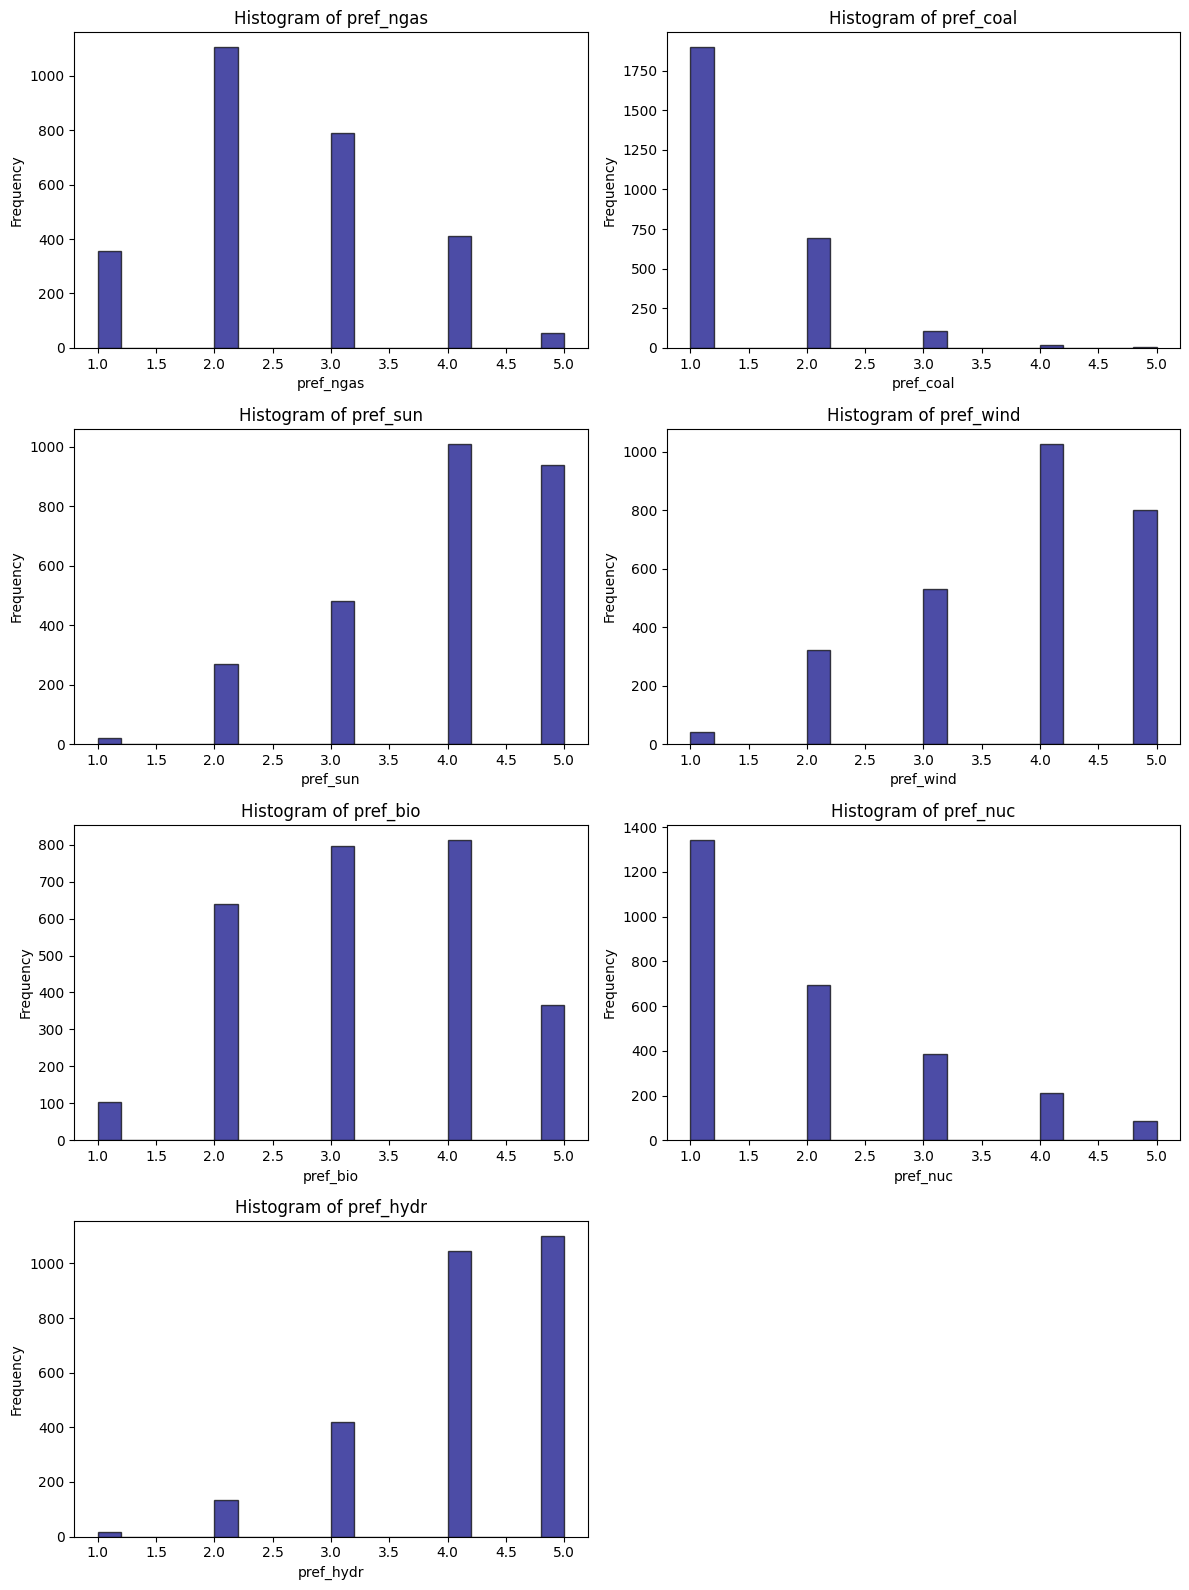

In [21]:
plot_individual_histograms(df, pref_cols)

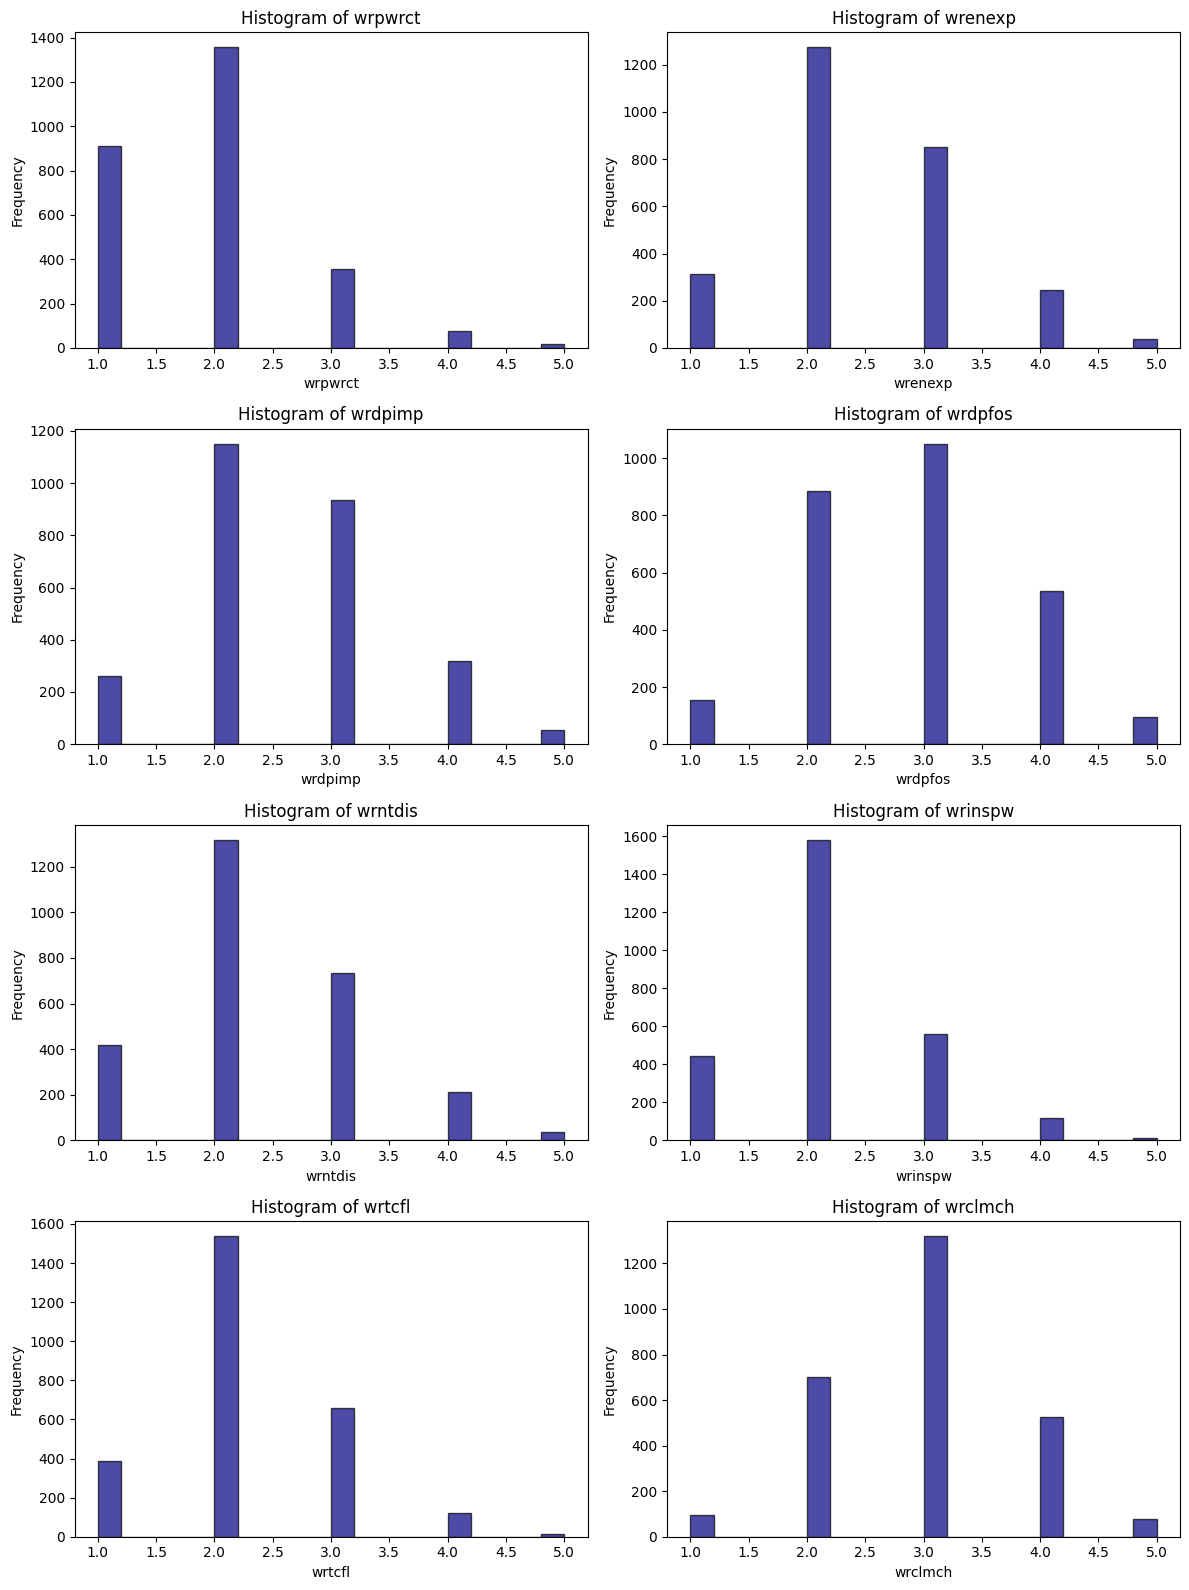

In [22]:
plot_individual_histograms(df, worry_cols)

#### Heatmaps for country-specific responses

The heatmaps below allow a direct comparison of the different views in NO and SE. It becomes evident, that hydropower is even more popular in NO and that nuclear power enjoys more support in SE. This fits well since Norway uses more hydro and no nuclear in contrast to SE.

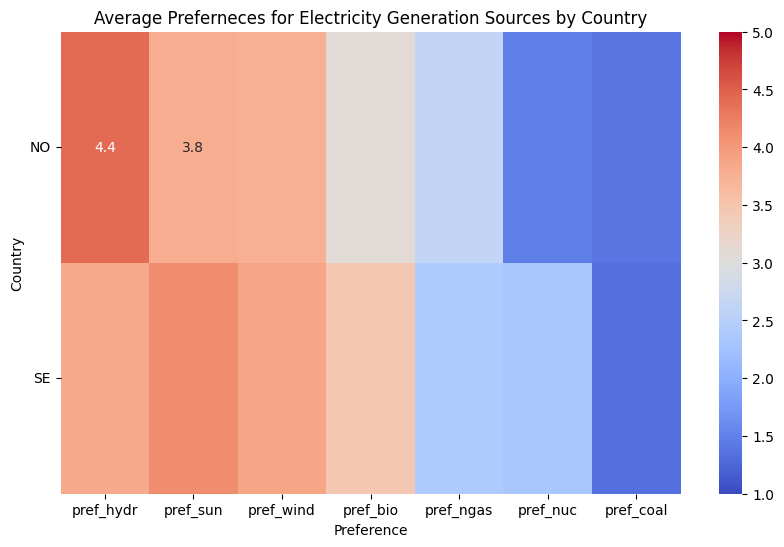

In [23]:
heatmaps(df, pref_cols, 1, 5, "Average Preferneces for Electricity Generation Sources by Country")

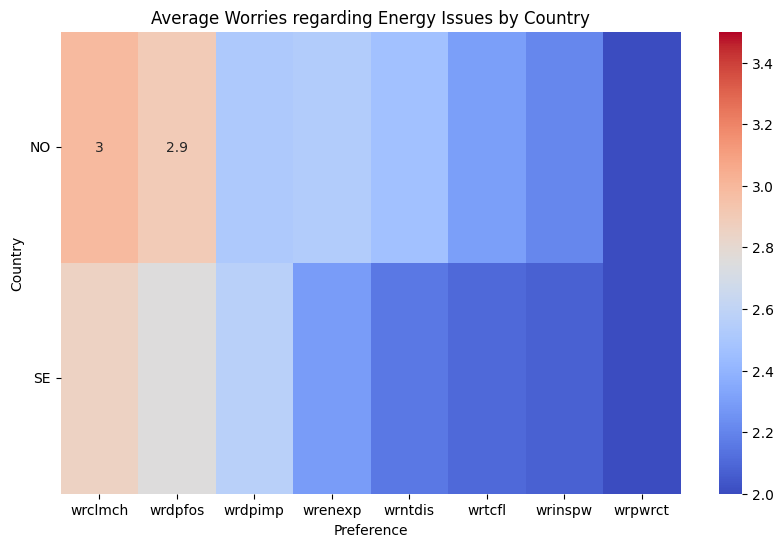

In [24]:
heatmaps(df, worry_cols, 2, 3.5, "Average Worries regarding Energy Issues by Country")

#### Spearman Corr Calculation

Now, different correlation matrixes are calculated. One observation, for example, is that support for coal correlates a bit more with the support for natural gas than other sources. Also, support for the different renewables is positively correlated - between sun and wind power even quite strongly. 

**Energy Preferences**

In [25]:
# Calling the correlation function for the energy preference variables:
corr_matrix_pref_pref, p_matrix_pref_pref = corr_func(pref_cols, pref_cols)
print("Spearman's Rank Correlation Coefficients Matrix:")
print(corr_matrix_pref_pref)
print("---------")
print("P Values for the Corr Matrix:")
print(p_matrix_pref_pref)

Spearman's Rank Correlation Coefficients Matrix:
          pref_ngas pref_coal  pref_sun pref_wind  pref_bio  pref_nuc  \
pref_ngas       1.0  0.236679  0.100797   0.10193  0.157332 -0.014053   
pref_coal  0.236679       1.0  0.010421  0.062951  0.080762   0.10894   
pref_sun   0.100797  0.010421       1.0  0.625202  0.317852 -0.050335   
pref_wind   0.10193  0.062951  0.625202       1.0  0.303522 -0.078141   
pref_bio   0.157332  0.080762  0.317852  0.303522       1.0  0.007532   
pref_nuc  -0.014053   0.10894 -0.050335 -0.078141  0.007532       1.0   
pref_hydr  0.061766 -0.012437  0.041354  0.107415  0.002911 -0.090634   

          pref_hydr  
pref_ngas  0.061766  
pref_coal -0.012437  
pref_sun   0.041354  
pref_wind  0.107415  
pref_bio   0.002911  
pref_nuc  -0.090634  
pref_hydr       1.0  
---------
P Values for the Corr Matrix:
          pref_ngas pref_coal  pref_sun pref_wind  pref_bio  pref_nuc  \
pref_ngas       0.0       0.0       0.0       0.0       0.0  0.463865   
pref

**Worries**

In [26]:
# Calling the correlation function for the energy worry variables:
corr_matrix_worry_worry, p_matrix_worry_worry = corr_func(worry_cols, worry_cols)
print("Spearman's Rank Correlation Coefficients Matrix:")
print(corr_matrix_worry_worry)
print("---------")
print("P Values for the Corr Matrix:")
print(p_matrix_worry_worry)

Spearman's Rank Correlation Coefficients Matrix:
          wrpwrct   wrenexp   wrdpimp   wrdpfos   wrntdis   wrinspw    wrtcfl  \
wrpwrct       1.0  0.367672  0.249349  0.170898  0.455386  0.367469  0.430088   
wrenexp  0.367672       1.0  0.435673  0.294859  0.402891  0.393988  0.377289   
wrdpimp  0.249349  0.435673       1.0  0.496007  0.342812  0.415358  0.332285   
wrdpfos  0.170898  0.294859  0.496007       1.0  0.301532  0.306093  0.243607   
wrntdis  0.455386  0.402891  0.342812  0.301532       1.0  0.523699  0.549959   
wrinspw  0.367469  0.393988  0.415358  0.306093  0.523699       1.0  0.490934   
wrtcfl   0.430088  0.377289  0.332285  0.243607  0.549959  0.490934       1.0   
wrclmch  0.131454  0.099066  0.103662  0.261453  0.213618  0.167303  0.126633   

          wrclmch  
wrpwrct  0.131454  
wrenexp  0.099066  
wrdpimp  0.103662  
wrdpfos  0.261453  
wrntdis  0.213618  
wrinspw  0.167303  
wrtcfl   0.126633  
wrclmch       1.0  
---------
P Values for the Corr Matrix:
 

**Worries X Preferences**

As a last step, the correlation betweeen energy worries and preferences is calculated and shown in a heat map. Many of the correlation coefficients are significant according to the p-value matrix but the coefficients are all so small that the interpretation of the direction is questionable. 

In [27]:
# Calling the correlation function for the cross-correlation between energy preference and worry variables:
corr_matrix_worry_pref, p_matrix_worry_pref = corr_func(worry_cols, pref_cols)
print("Spearman's Rank Correlation Coefficients Matrix:")
print(corr_matrix_worry_pref)
print("---------")
print("P Values for the Corr Matrix:")
print(p_matrix_worry_pref)

Spearman's Rank Correlation Coefficients Matrix:
        pref_ngas pref_coal  pref_sun pref_wind  pref_bio  pref_nuc pref_hydr
wrpwrct  0.036998  0.026932 -0.031048  -0.04713  -0.03955 -0.086546 -0.014727
wrenexp  0.105952  0.087666  0.055253  0.042729  0.022895 -0.052601  0.020645
wrdpimp  0.052169  0.063458  0.081429   0.07802  0.059682    0.0195 -0.046925
wrdpfos  0.019651  0.016074  0.137883   0.16021  0.055135 -0.078208 -0.003158
wrntdis  0.094136   0.07827  0.044706   0.05184  0.049856 -0.119878  0.016386
wrinspw  0.088563   0.10233  0.038767  0.072782  0.039972 -0.013966   0.00479
wrtcfl     0.0889  0.076237 -0.003112   0.01166  0.009517 -0.058683  0.020608
wrclmch -0.063006 -0.023097  0.097546  0.125356   0.09587 -0.121418  -0.00652
---------
P Values for the Corr Matrix:
        pref_ngas pref_coal  pref_sun pref_wind  pref_bio  pref_nuc pref_hydr
wrpwrct  0.053728   0.16034   0.10553  0.013979  0.039191  0.000006  0.442721
wrenexp       0.0  0.000005  0.003952  0.025877  0.23

Heatmap for the above correlation table: 

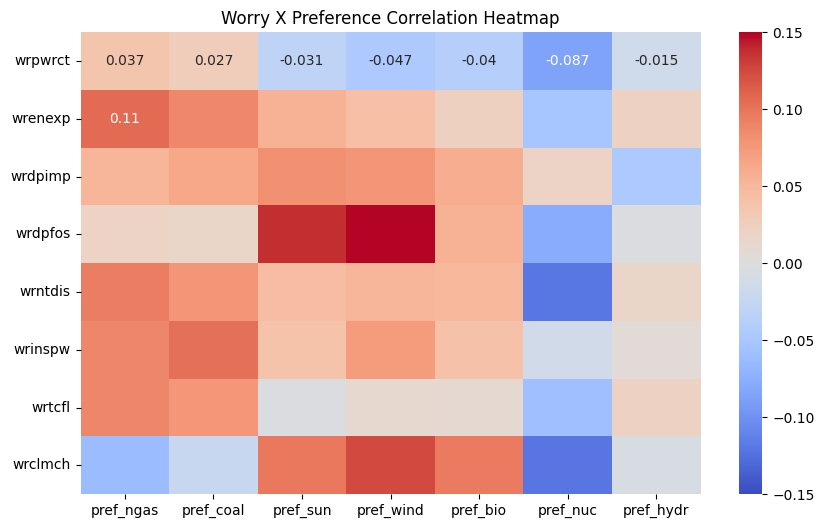

In [28]:
heatmaps_corr(corr_matrix_worry_pref, -0.15,0.15,"Worry X Preference Correlation Heatmap")